In [8]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

🔄 Loading models...
✅ Models loaded.

image 1/1 /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/test/images/1061.jpg: 640x384 1 license_plate, 149.5ms
Speed: 4.0ms preprocess, 149.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


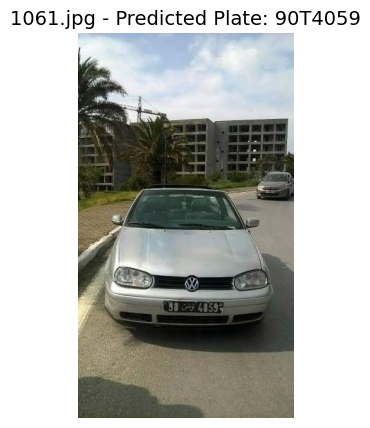


image 1/1 /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/test/images/906.jpg: 384x640 1 license_plate, 158.4ms
Speed: 3.9ms preprocess, 158.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


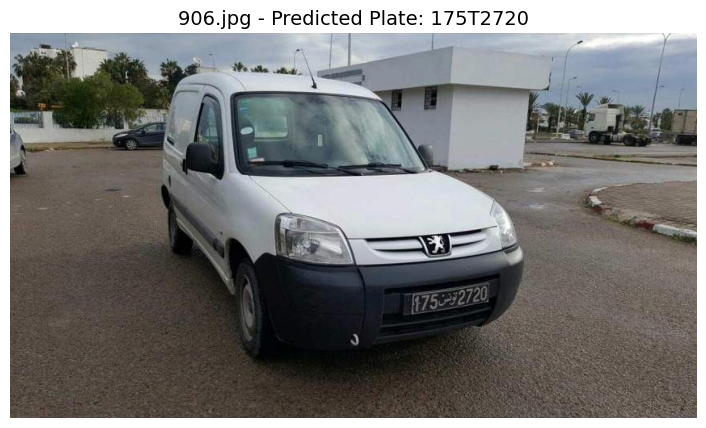


image 1/1 /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/test/images/965.jpg: 640x480 1 license_plate, 200.4ms
Speed: 13.7ms preprocess, 200.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


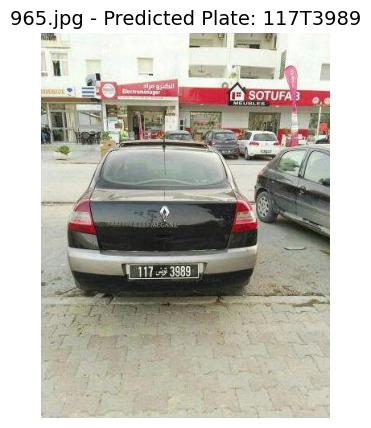


image 1/1 /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/test/images/1071.jpg: 640x480 1 license_plate, 192.3ms
Speed: 4.4ms preprocess, 192.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


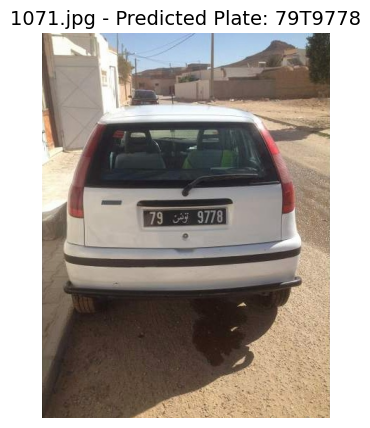


image 1/1 /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/test/images/944.jpg: 640x480 1 license_plate, 193.1ms
Speed: 4.4ms preprocess, 193.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


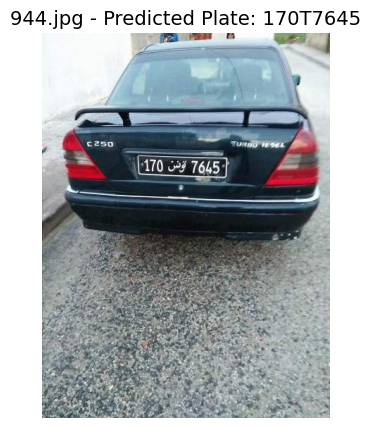

In [2]:
import os
import cv2
import torch
import string
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torch import nn

# === CONFIG ===
YOLO_MODEL_PATH = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/plate_detector_v2/weights/best.pt"
MODEL_SAVE_PATH = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/ocr_crnn_best.pth"
FULL_CAR_IMG_DIR = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/test/images"
IMG_WIDTH, IMG_HEIGHT = 160, 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CHARS = string.digits + string.ascii_uppercase + 'T'
CHAR_TO_IDX = {c: i+1 for i, c in enumerate(CHARS)}
IDX_TO_CHAR = {i: c for c, i in CHAR_TO_IDX.items()}

# === CRNN Model ===
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d((2, 1)),
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2, 1)),
        )
        self.rnn = nn.LSTM(1024, 256, bidirectional=True, num_layers=2, batch_first=True)
        self.fc = nn.Linear(512, num_classes + 1)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2).contiguous().view(b, w, c * h)
        x, _ = self.rnn(x)
        x = self.fc(x[:, :, :512])
        return x.permute(1, 0, 2)

# === Decode Prediction ===
def decode_prediction(logits):
    pred = torch.argmax(logits, dim=2).permute(1, 0)
    results = []
    for seq in pred:
        prev = -1
        text = ""
        for idx in seq:
            idx = idx.item()
            if idx != prev and idx != 0:
                text += IDX_TO_CHAR.get(idx, "?")
            prev = idx
        results.append(text)
    return results

# === Load Models Once ===
print("🔄 Loading models...")
yolo = YOLO(YOLO_MODEL_PATH)
crnn = CRNN(len(CHARS)).to(DEVICE)
crnn.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
crnn.eval()
print("✅ Models loaded.")

# === Get 5 Random Images ===
all_images = [f for f in os.listdir(FULL_CAR_IMG_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
random_images = random.sample(all_images, 5)

# === Inference + Display ===
for idx, img_name in enumerate(random_images, 1):
    img_path = os.path.join(FULL_CAR_IMG_DIR, img_name)

    # YOLO inference (prints automatically)
    results = yolo(img_path)

    # Read full image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get YOLO box
    boxes = results[0].boxes.xyxy.cpu().numpy()
    plate_crop = None
    if len(boxes) > 0:
        x1, y1, x2, y2 = map(int, boxes[0][:4])
        plate_crop = img[y1:y2, x1:x2]

    # Run OCR
    prediction = "No plate detected"
    if plate_crop is not None:
        gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (IMG_WIDTH, IMG_HEIGHT))
        norm = resized / 255.0
        input_tensor = torch.tensor(norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = crnn(input_tensor)
        decoded = decode_prediction(logits)
        prediction = decoded[0]

    # Display the image with prediction
    plt.figure(figsize=(10, 5))
    plt.imshow(img_rgb)
    plt.title(f"{img_name} - Predicted Plate: {prediction}", fontsize=14)
    plt.axis('off')
    plt.show()